In [ ]:
!pip install tensorflow keras seaborn opencv-python


1. Library Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from google.colab import files


2. Upload and Read CSV

In [ ]:
uploaded = files.upload()  # Upload your spreadsheet-exported CSV
df = pd.read_csv(next(iter(uploaded)))
# Clean column names
df.columns = df.columns.str.strip().str.replace('\n', '', regex=True).str.replace('\r', '', regex=True)

Saving calories.csv to calories.csv


In [ ]:
# Auto-detect the calorie column
cal_column = [col for col in df.columns if 'Cal' in col and '100' in col][0]

# Extract numeric values from strings like "46 cal"
df['Cals_per100grams'] = (
    df[cal_column]
    .astype(str)
    .str.extract(r'(\d+\.?\d*)')  # Extract numbers
    .astype(float)
)

# Categorize calorie levels
def categorize_calories(cal):
    if pd.isna(cal):
        return 'Unknown'
    elif cal < 100:
        return 'Low'
    elif cal < 250:
        return 'Medium'
    else:
        return 'High'

df['Calorie_Level'] = df['Cals_per100grams'].apply(categorize_calories)
print(df[['FoodItem', 'Cals_per100grams', 'Calorie_Level']].head())


              FoodItem  Cals_per100grams Calorie_Level
0           Applesauce              62.0           Low
1      Canned Apricots              48.0           Low
2  Canned Blackberries              92.0           Low
3   Canned Blueberries              88.0           Low
4      Canned Cherries              54.0           Low


4. Identify Calorie Column

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['FoodItem'])
y = df['Calorie_Level']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)


SVC(kernel='linear')

5. Extract Numeric Calories

In [ ]:
def predict_from_text(food_name):
    vec = vectorizer.transform([food_name])
    pred = svm_model.predict(vec)[0]
    match = df[df['FoodItem'].str.lower() == food_name.lower()]
    cal = match['Cals_per100grams'].values[0] if not match.empty else "Unknown"
    return f"{food_name.title()} → Estimated Calories: {cal}, Category: {pred}"

food_input = input("Enter a food name: ")
print(predict_from_text(food_input))


Enter a food name: apple
Apple → Estimated Calories: 52.0, Category: Medium


In [ ]:
uploaded_img = files.upload()  # Upload a food image
img_path = next(iter(uploaded_img))

img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

model = MobileNetV2(weights='imagenet')
preds = model.predict(x)
label = decode_predictions(preds, top=1)[0][0][1]

match = df[df['FoodItem'].str.lower() == label.lower()]
if not match.empty:
    cal = match['Cals_per100grams'].values[0]
    level = categorize_calories(cal)
    print(f"🧠 Predicted: {label.title()} → Calories: {cal}, Category: {level}")
else:
    print(f"🧠 Predicted: {label.title()} → Not found in calorie database.")


Saving 360_F_381697040_XDxtwqVnsdNs5osEvXUGUlwsMBJvMi7k.jpg to 360_F_381697040_XDxtwqVnsdNs5osEvXUGUlwsMBJvMi7k.jpg
14536120/14536120 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
🧠 Predicted: Banana → Calories: 89.0, Category: Low


<Axes: ylabel='count'>

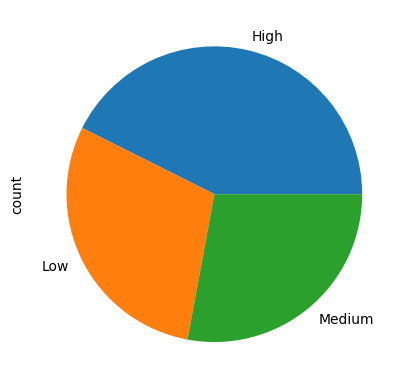

In [ ]:
df['Calorie_Level'].value_counts().plot(kind='pie')
